# Stochastic Gradient Descent From Scratch

This notebook illustrates the nature of the Stochastic Gradient Descent (SGD) and walks through all the necessary steps to create SGD from scratch in Python. Gradient Descent is an essential part of many machine learning algorithms, including neural networks. To understand how it works you will need some basic math and logical thinking. Though a stronger math background would be preferable to understand derivatives, I will try to explain them as simple as possible.

We will work with the California housing dataset and perform a linear regression to predict apartment prices based on the median income in the block. We will start from the simple linear regression and gradually finish with Stochastic Gradient Descent. So let's get started.

## Importing Libraries

In [1]:
from numpy import mean, array, full
from numpy.random import choice
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import california_housing
from sklearn.metrics import mean_squared_error

## California Housing Dataset

Scikit-learn comes with wide variety of datasets for regression, classification and other problems. Lets load our data into pandas dataframe and take a look.

In [2]:
housing_data = california_housing.fetch_california_housing()

In [3]:
Features = pd.DataFrame(housing_data.data, columns=housing_data.feature_names)
Target = pd.DataFrame(housing_data.target, columns=['Target'])

In [4]:
df = Features.join(Target)

In [5]:
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


Features as `MedInc` and `Target` were scaled to some degree.

In [6]:
df.corr()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target
MedInc,1.000000,-0.119034,0.326895,-0.062040,0.004834,0.018766,-0.079809,-0.015176,0.688075
HouseAge,-0.119034,1.000000,-0.153277,-0.077747,-0.296244,0.013191,0.011173,-0.108197,0.105623
AveRooms,0.326895,-0.153277,1.000000,0.847621,-0.072213,-0.004852,0.106389,-0.027540,0.151948
AveBedrms,-0.062040,-0.077747,0.847621,1.000000,-0.066197,-0.006181,0.069721,0.013344,-0.046701
Population,0.004834,-0.296244,-0.072213,-0.066197,1.000000,0.069863,-0.108785,0.099773,-0.024650
AveOccup,0.018766,0.013191,-0.004852,-0.006181,0.069863,1.000000,0.002366,0.002476,-0.023737
Latitude,-0.079809,0.011173,0.106389,0.069721,-0.108785,0.002366,1.000000,-0.924664,-0.144160
Longitude,-0.015176,-0.108197,-0.027540,0.013344,0.099773,0.002476,-0.924664,1.000000,-0.045967
Target,0.688075,0.105623,0.151948,-0.046701,-0.024650,-0.023737,-0.144160,-0.045967,1.000000


In [7]:
df[['MedInc', 'Target']].describe()

,MedInc,Target
count,20640.000000,20640.000000
mean,3.870671,2.068558
std,1.899822,1.153956
min,0.499900,0.149990
25%,2.563400,1.196000
50%,3.534800,1.797000
75%,4.743250,2.647250
max,15.000100,5.000010


## Preprocessing: Removing Outliers and Scaling

It seems that `Target` has some outliers (as well as `MedInc`), because 75% of the data has price less than 2.65, but maximum price go as high as 5. We're going to remove extremely expensive houses as they will add unnecessary noize to the data.

In [8]:
df = df[df.Target < 5]

We will also scale `MedInc` and `Target` variables to [0-1].

In [9]:
def scale(x):
    min = x.min()
    max = x.max()
    return pd.Series([(i - min)/(max - min) for i in x])

X = scale(df.MedInc)
y = scale(df.Target)

In [10]:
X.max(), y.max() # features are scaled now

(1.0, 1.0)

## Correlative Between Price and Income

Visually we can determine what kind of accuracy we can expect from the models.

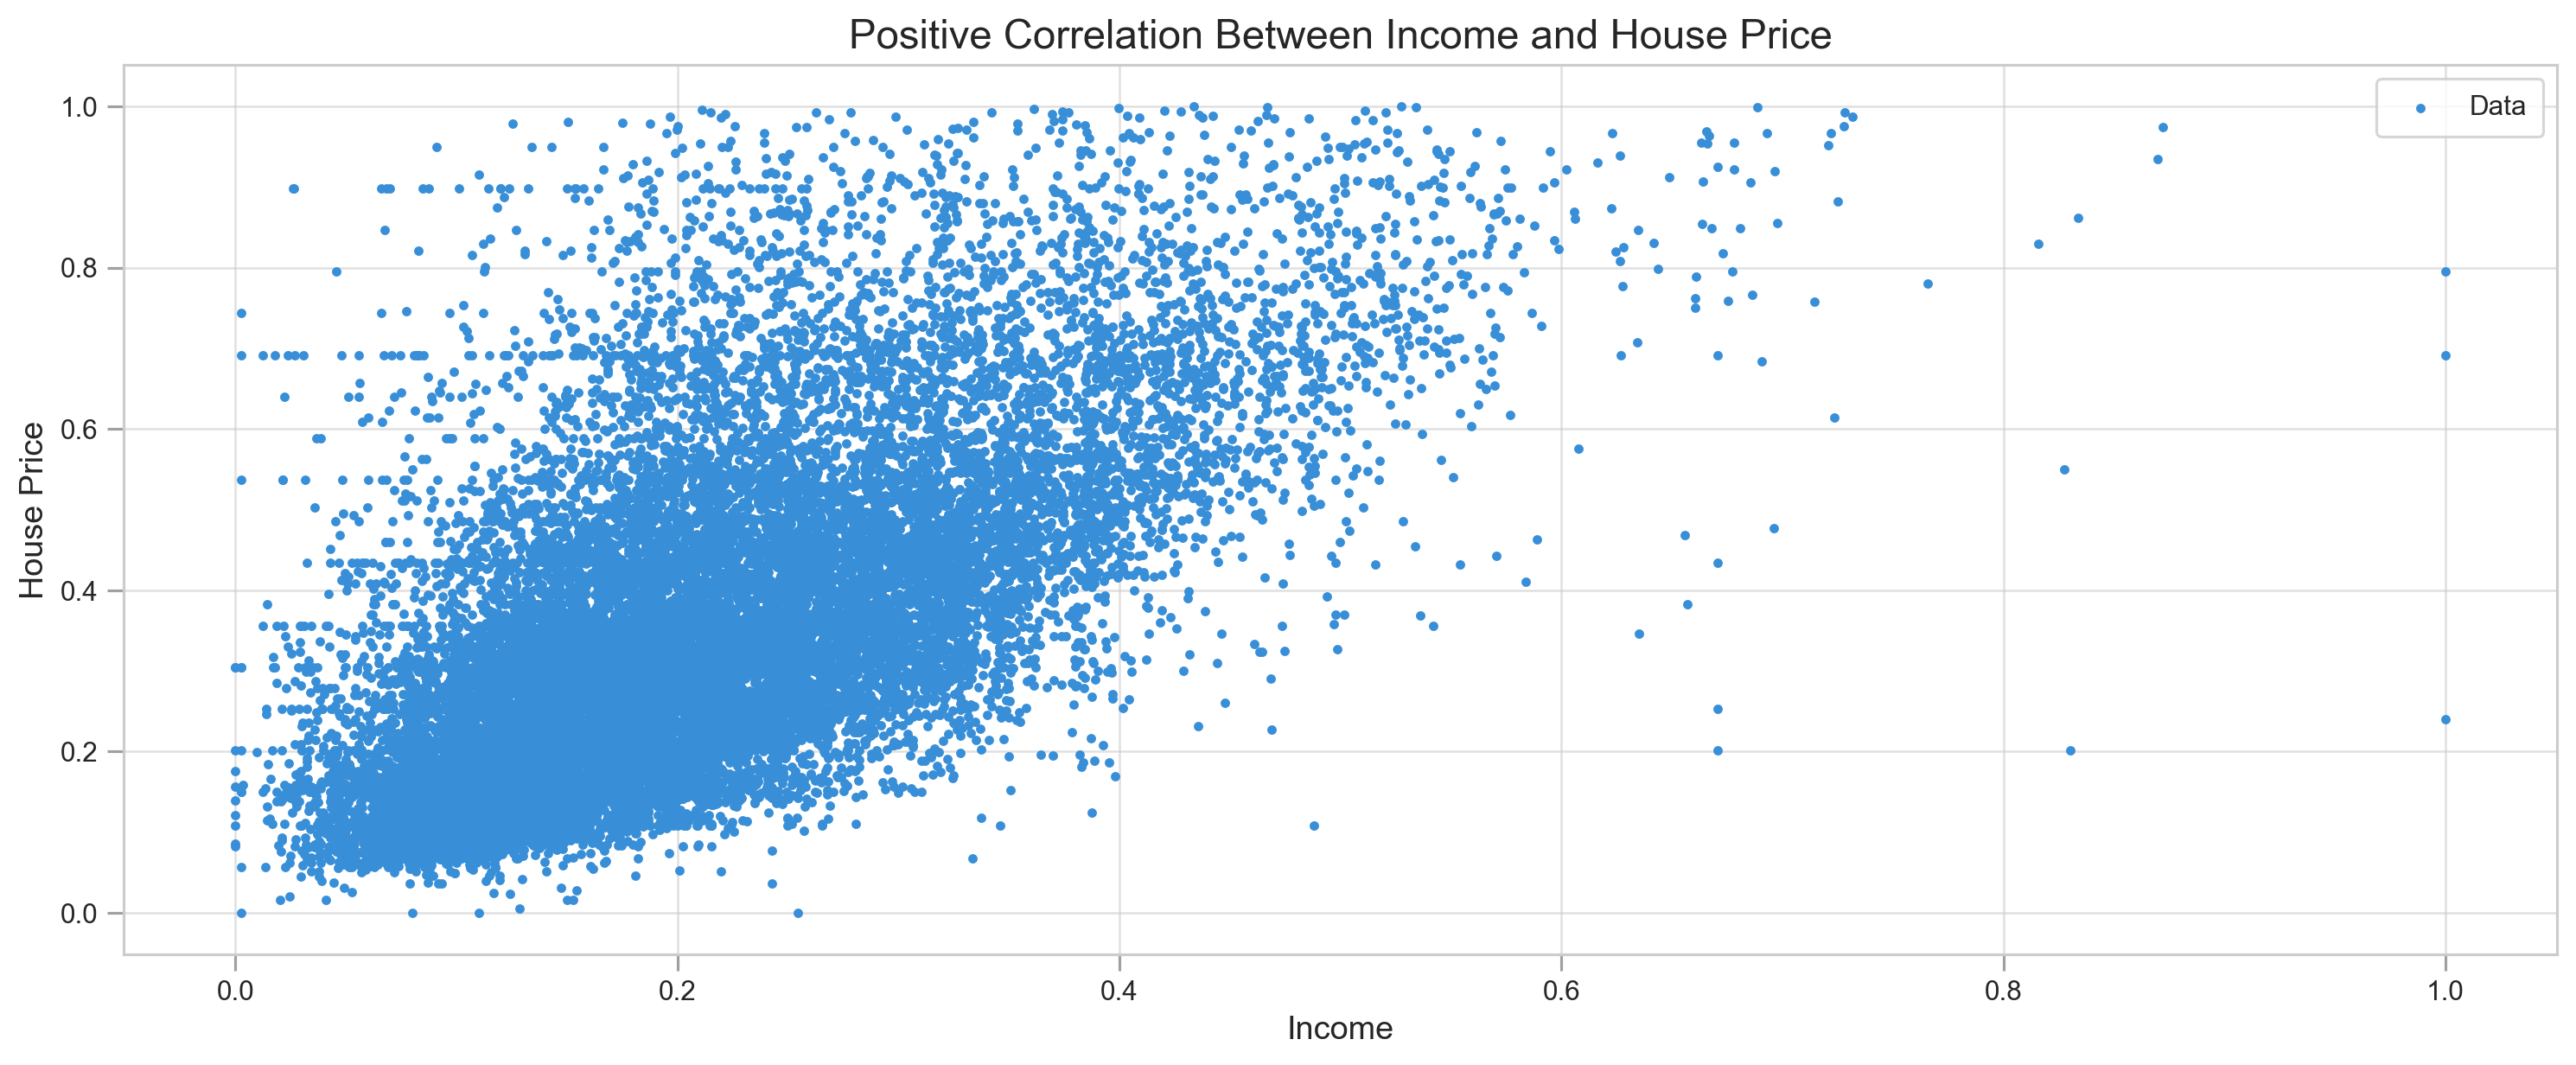

In [24]:
plt.figure(figsize=(16,6))
plt.rcParams['figure.dpi'] = 227
plt.style.use('seaborn-whitegrid')
plt.scatter(X, y, label='Data', c='#388fd8', s=6)
plt.title('Positive Correlation Between Income and House Price', fontSize=15)
plt.xlabel('Income', fontSize=12)
plt.ylabel('House Price', fontSize=12)
plt.legend(frameon=True, loc=1, fontsize=10, borderpad=.6)
plt.tick_params(direction='out', length=6, color='#a0a0a0', width=1, grid_alpha=.6)
plt.show()

Data is quite sparse, but we can still observe some linearity.

# Simple Linear Regression

Simple linear regression can be described by only two parameters: slope `m` and intercept `b`, where `x` is our **median income**. Lets take a look at the formulas below:

# $$\hat{y} = mx + b$$

### $$m = \frac{\overline{x}\overline{y}-\overline{xy}}{(\overline{x})^2 - \overline{x^2}} \quad \textrm{and} \quad  b = y-mx$$

If we want to add some other features, like size of the apartment, our formula would look like this: $\hat{y} = m_1x_1 + m_2x_2 + b$, where $m_1$ and $m_2$ are slopes for each feature $x_1$ and $x_2$. In this case we would call it multiple linear regression, but we could no longer use formulas above.

In [12]:
class LinearRegression:
        
    def fit(self, X, y):
        self.X = X
        self.y = y
        self.m = ((mean(X) * mean(y) - mean(X*y)) / ((mean(X)**2) - mean(X**2)))
        self.b = mean(y) - self.m * mean(X)
    
    def coeffs(self):
        return self.m, self.b
    
    def predict(self):
        self.y_pred = self.m * self.X + self.b
        return self.y_pred
    
    def r_squared(self):
        self.y_mean = full((len(self.y)), mean(self.y))
        err_reg = sum((self.y - self.y_pred)**2)
        err_y_mean = sum((self.y - self.y_mean)**2)
        return (1 - (err_reg/err_y_mean))

In [13]:
def plot_regression(X, y, y_pred, log=None, title="Linear Regression"):
    
    plt.figure(figsize=(16,6))
    plt.rcParams['figure.dpi'] = 227
    plt.scatter(X, y, label='Data', c='#388fd8', s=6)
    if log != None:
        for i in range(len(log)):
            plt.plot(X, log[i][0]*X + log[i][1], lw=1, c='#caa727', alpha=0.15)
    plt.plot(X, y_pred, c='#ff7702', lw=3, label='Regression')
    plt.title(title, fontSize=14)
    plt.xlabel('Income', fontSize=11)
    plt.ylabel('Price', fontSize=11)
    plt.legend(frameon=True, loc=1, fontsize=10, borderpad=.6)
    plt.tick_params(direction='out', length=6, color='#a0a0a0', width=1, grid_alpha=.6)
    plt.show()

In [14]:
linreg = LinearRegression()

In [15]:
linreg.fit(X, y)

In [16]:
y_pred = linreg.predict()

MSE: 0.023408891983089833


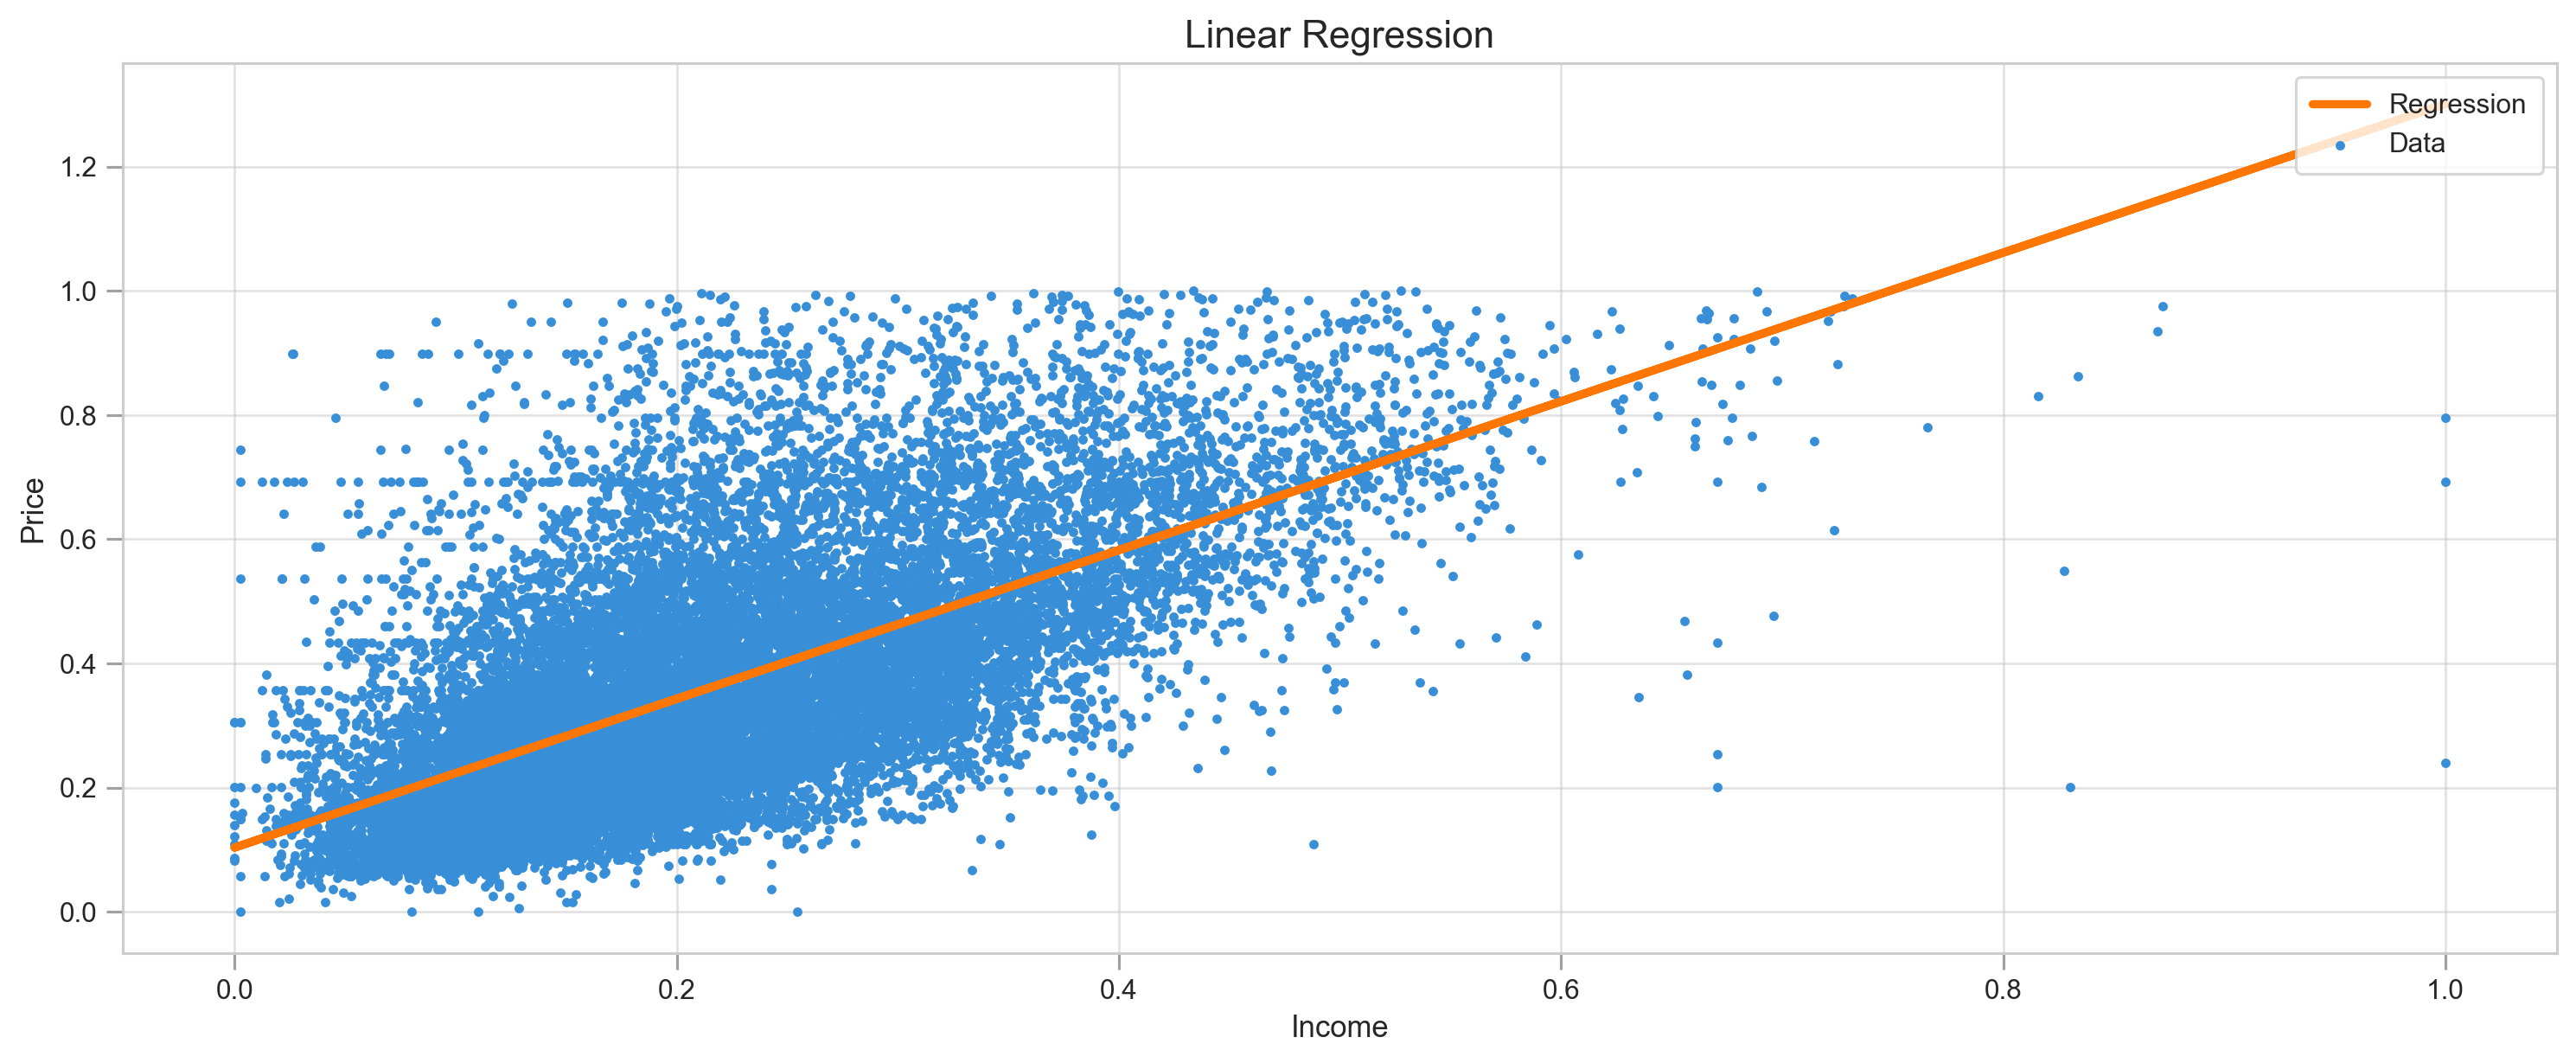

In [17]:
print("MSE:",mean_squared_error(y, y_pred))
plot_regression(X, y, y_pred, title="Linear Regression")

Result of our model is the regression line. Just by looking at the graph we can tell that data points go well above and beyond our line, making predictions approximate.

# Gradient Descent

### Abstract

The idea behind gradient descent is simple - by gradually tuning parameters, such as slope (`m`) and the intercept (`b`) in our regression function `y = mx + b`, we minimize cost. 
By cost, we usually mean some kind of a function that tells us how far off our model predicted result. For regression problems we often use `mean squared error` (MSE) cost function. If we use gradient descent for the classification problem, we will have a different set of parameters to tune.

### $$ MSE = \frac{1}{n}\sum_{i=1}^{n} (y_i - \hat{y_i})^2 \quad \textrm{where} \quad \hat{y_i} = mx_i + b $$

Now we have to figure out how to tweak parameters `m` and `b` to reduce MSE.

### Partial Derivatives

We use partial derivatives to find how each individual parameter affects MSE, so that's where word _partial_ comes from. In simple words, we take the derivative with respect to `m` and `b` **separately**. Take a look at the formula below. It looks almost exactly the same as MSE, but this time we added f(m, b) to it. It essentially changes nothing, except now we can plug `m` and `b` numbers into it and calculate the result.

### $$𝑓(𝑚,𝑏)= \frac{1}{n}\sum_{i=1}^{n}(y_i - (mx_i+b))^2$$

Now we have to figure out how to take partial derivative with respect to parameter `m` and `b`. We can ignore sum and what comes before that and focus only on $y - (mx + b)^2$.

### Partical Derivative With Respect to `m`

With respect to `m` means we derive parameter `m` and basically ignore what is going on with `b`, or we can say its 0. To derive with respect to `m` we will use chain rule.

Chain rule is when one function inside another. If you're new to this, you'd be surprised that $()^2$ is outside function, and $y-(mx+b)$ is inside. So, the chain rule says that we should take a derivative of outside function, multiply it by inside function and then multiply by derivative of the inside function.

 1. $()^2$ becomes $2()$, same as $x^2$ becomes $2x$
 2. $y - (mx + b)$ stays the same
 3. $y - (mx + b)$ becomes $(0 - (x + 0))$ or $-x$, because **_y_** and **_b_** are constants, they become 0, and derivative of **_mx_** is **_x_**
 
Multiply all parts we get following: $2 * (y - (mx+b)) * -x$. 
Looks nicer if we move -x to the left: $-2x *(y-(mx+b))$

### $$\frac{\partial f}{\partial m} = \frac{1}{n}\sum_{i=1}^{n}-2x_i(y_i - (mx_i+b))$$

### Partical Derivative With Respect to `b`

1. $()^2$ becomes $2()$, same as $x^2$ becomes $2x$
2. $y - (mx + b)$ stays the same
3. $y - (mx + b)$ becomes $(0 - (0 + 1))$ or $-1$, because **_y_** and **_mx_** are constants, they become 0, and derivative of **_b_** is 1

Multiply all the parts together and we get $-2(y-(mx+b))$

### $$\frac{\partial f}{\partial b} = \frac{1}{n}\sum_{i=1}^{n}-2(y_i - (mx_i+b))$$

The hardest part is over, now we can code our functions in Python.

### Final Function

Few details we should discuss befor jumping into code:
1. Gradient descent is an iterative process and with each iteration (`epoch`) we slightly minimizing MSE
2. Because its iterative, we should choose how many iterations we take, or make algorithm stop when we approach minima of MSE
3. Gradient descent has additional parameter learning rate (`lr`), which helps control how fast or slow algorithm going towards minima of MSE

In [18]:
def gradient_descent(X, y, lr=0.05, epoch=10):
    
    '''
    Gradient Descent for a single feature
    '''
    
    m, b = 0, 0 # parameters
    log, mse = [], [] # lists to store learning process
    N = len(X) # number of samples
    
    for _ in range(epoch):
                
        # Derivative for m and b

        f = m*X + b
        m_derivative = -2 * sum(X * (y - f)) / N
        b_derivative = -2 * sum(y - f) / N
    
        # Updating m and b
        m -= lr * m_derivative
        b -= lr * b_derivative
        
        log.append((m, b))
        mse.append(mean_squared_error(y, (m*X + b)))        
    
    return m, b, log, mse

### Predicting House Price With Gradient Descent

MSE: 0.024403781659275047


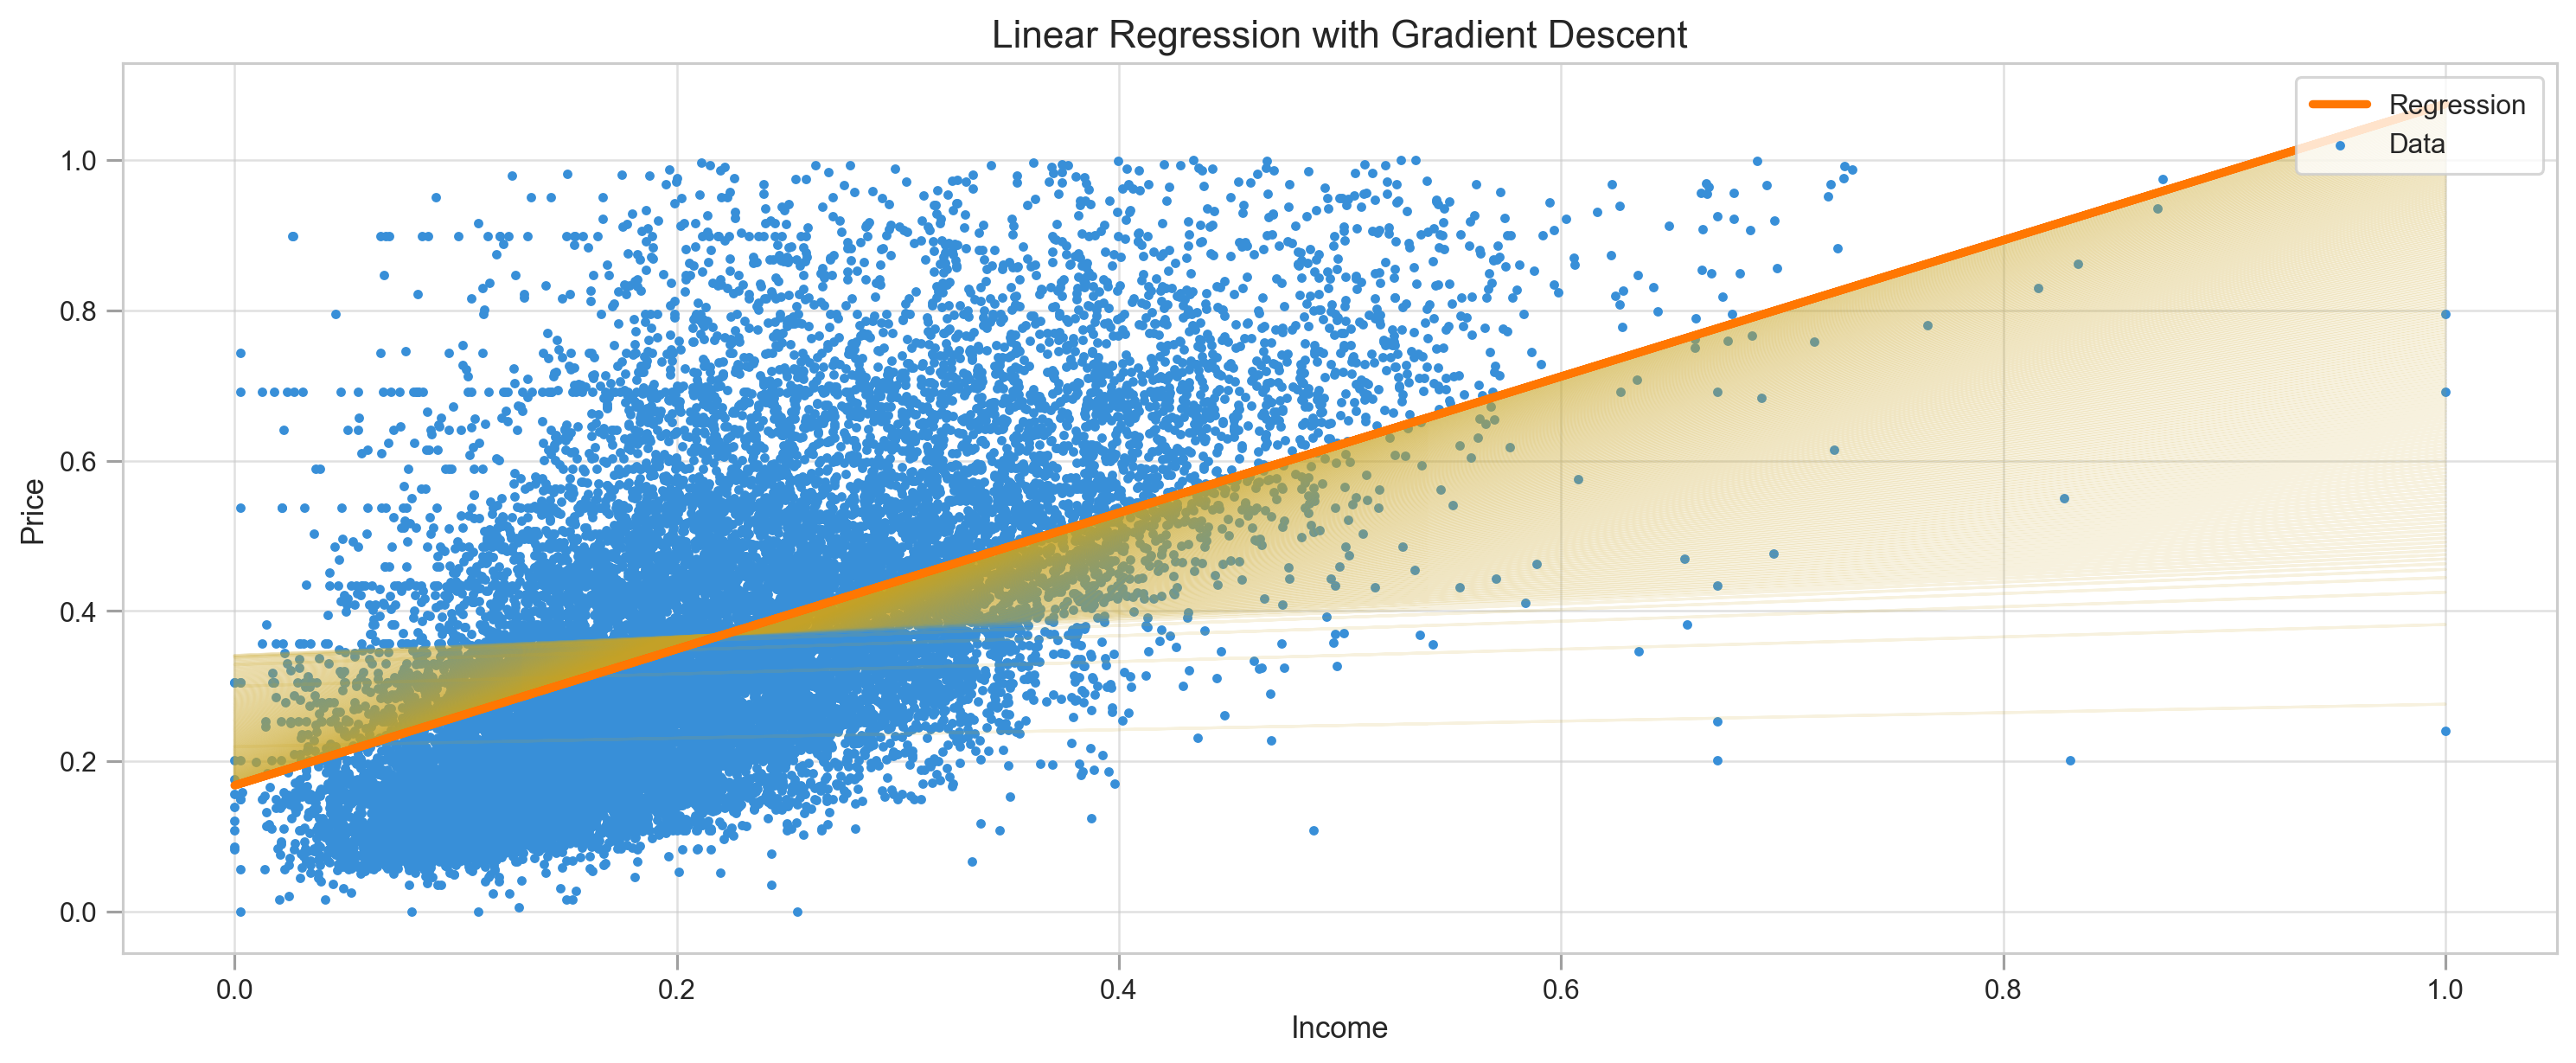

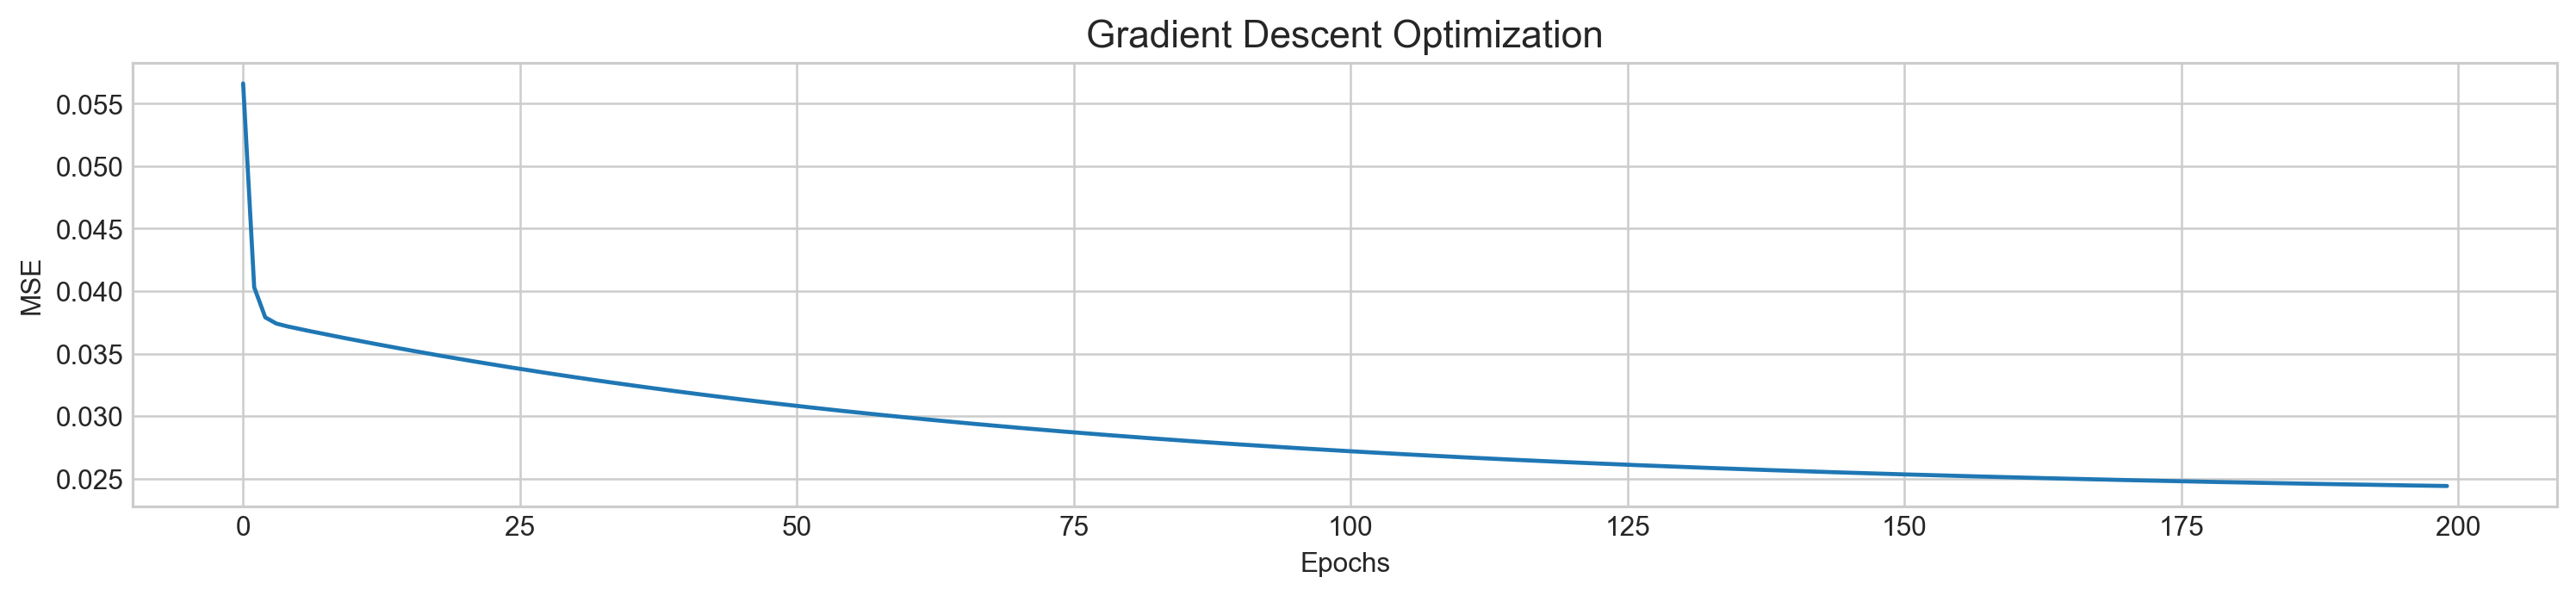

In [19]:
m, b, log, mse = gradient_descent(X, y, lr=0.3, epoch=200)

y_pred = m*X + b

print("MSE:",mean_squared_error(y, y_pred))
plot_regression(X, y, y_pred, log=log, title="Linear Regression with Gradient Descent")

plt.figure(figsize=(16,3))
plt.rcParams['figure.dpi'] = 227
plt.plot(range(len(mse)), mse)
plt.title('Gradient Descent Optimization', fontSize=14)
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

## Stochastic Gradient Descent

Stochastic Gradient Descent works almost the same as Gradient Descent (also called Batch Gradient Descent), but instead of training on entire dataset, it picks only one sample to update `m` and `b` parameters, which makes it much faster. In the function below I made possible to change sample size (`batch_size`), because sometimes its better to use more than one sample at a time.

In [20]:
def SGD(X, y, lr=0.05, epoch=10, batch_size=1):
        
    '''
    Stochastic Gradient Descent for a single feature
    '''
    
    m, b = 0, 0 # initial parameters
    log, mse = [], [] # lists to store learning process
    
    for _ in range(epoch):
        
        sample = choice(X.index, batch_size) # random sample
        
        Xs = X.get(sample)
        ys = y.get(sample)
        N = len(Xs)
        f = m*Xs + b
        
        # Calculating slope for m and b by taking derivatives
        m_derivative = -2 * sum(Xs * (ys - f)) / N
        b_derivative = -2 * sum(ys - f) / N
        
        # Updating parameters m and b
        m -= lr * m_derivative 
        b -= lr * b_derivative
        
        log.append((m, b))
        mse.append(mean_squared_error(y, m*X+b))        
    
    return m, b, log, mse

MSE: 0.02515584109064795


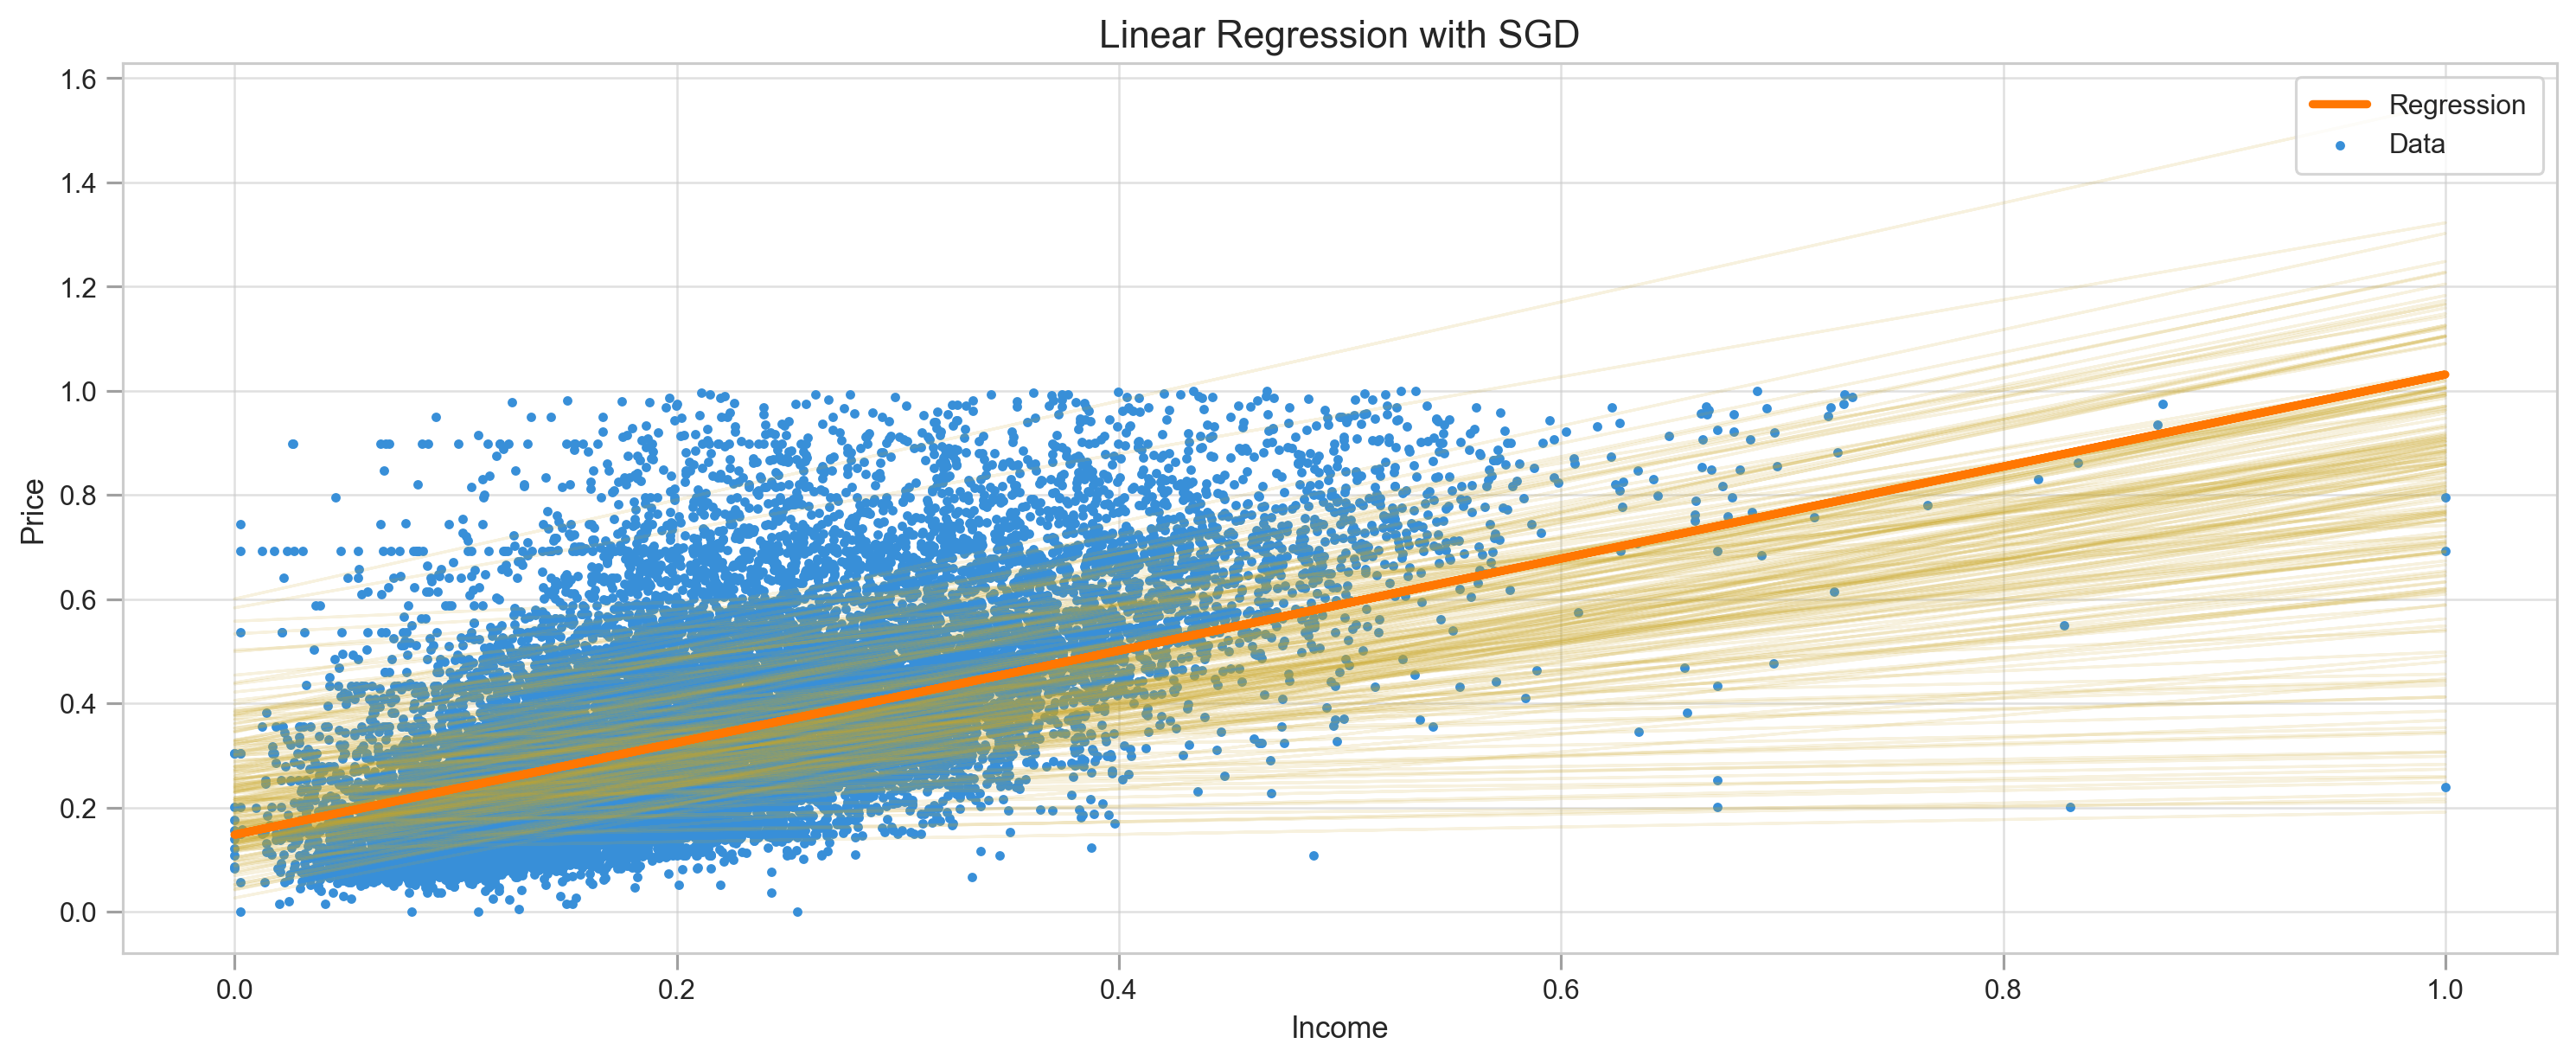

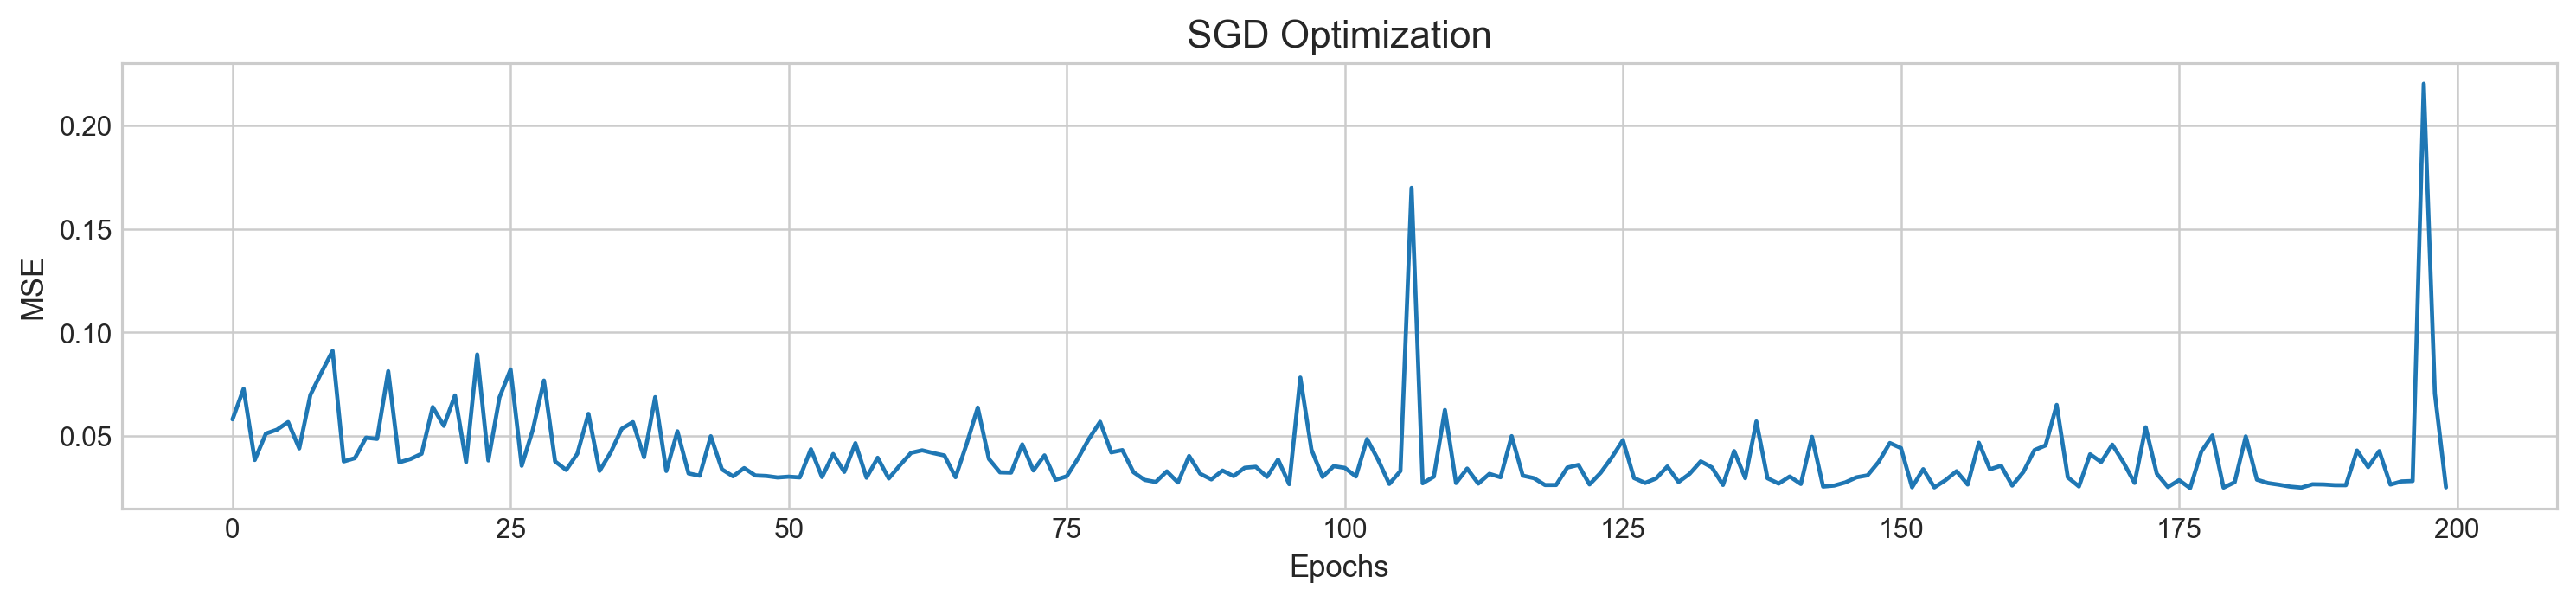

In [25]:
m, b, log, mse = SGD(X, y, lr=0.3, epoch=200, batch_size=1)

y_pred = m*X + b

print("MSE:",mean_squared_error(y, y_pred))
plot_regression(X, y, y_pred, log=log, title="Linear Regression with SGD")

plt.figure(figsize=(16,3))
plt.rcParams['figure.dpi'] = 227
plt.plot(range(len(mse)), mse)
plt.title('SGD Optimization', fontSize=14)
plt.xlabel('Epochs', fontSize=11)
plt.ylabel('MSE', fontSize=11)
plt.show()

We can observe how regression line went up and down to find right parameters and MSE not as smooth as regular gradient descent.

## Speed Test for Gradient Descent vs SGD

In [22]:
%timeit SGD(X, y, lr=0.01, epoch=1000, batch_size=1)

2.35 s ± 42.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [23]:
%timeit gradient_descent(X, y, lr=0.01, epoch=1000)

4.39 s ± 41.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Conclusion

1. SGD is twice as fast as Gradient Descent (also called Batch Gradient Descent)
2. On sparse data, we can increase the batch size to speed up learning process. It's not a pure form of SGD, but we can call it a mini-batch SGD
3. Smaller learning rate helps to prevent overfitting but can be adjusted accordingly